# Factor Analysis of NBA data


In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# !pip install factor_analyzer

<IPython.core.display.Javascript object>

In [3]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

data_url = "https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/Data%20Sets%20Clustering/nba_player_seasons.csv"
nba = pd.read_csv(data_url)
nba.head()

,Seas,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,2019,Álex Abrines,SG,25,OKC,31,2,19.0,1.8,5.1,...,0.923,0.2,1.4,1.5,0.6,0.5,0.2,0.5,1.7,5.3
1,2019,Quincy Acy,PF,28,PHO,10,0,12.3,0.4,1.8,...,0.700,0.3,2.2,2.5,0.8,0.1,0.4,0.4,2.4,1.7
2,2019,Jaylen Adams,PG,22,ATL,34,1,12.6,1.1,3.2,...,0.778,0.3,1.4,1.8,1.9,0.4,0.1,0.8,1.3,3.2
3,2019,Steven Adams,C,25,OKC,80,80,33.4,6.0,10.1,...,0.500,4.9,4.6,9.5,1.6,1.5,1.0,1.7,2.6,13.9
4,2019,Bam Adebayo,C,21,MIA,82,28,23.3,3.4,5.9,...,0.735,2.0,5.3,7.3,2.2,0.9,0.8,1.5,2.5,8.9


<IPython.core.display.Javascript object>

* Select just the numeric columns.
* Drop the `'Seas'` column
* Drop all NAs
* Display the top 5 rows

In [4]:
nba_num = nba.select_dtypes("number")
nba_num = nba_num.drop(columns=["Seas"])
nba_num = nba_num.dropna()
nba_num.head()

,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,25,31,2,19.0,1.8,5.1,0.357,1.3,4.1,0.323,...,0.923,0.2,1.4,1.5,0.6,0.5,0.2,0.5,1.7,5.3
1,28,10,0,12.3,0.4,1.8,0.222,0.2,1.5,0.133,...,0.700,0.3,2.2,2.5,0.8,0.1,0.4,0.4,2.4,1.7
2,22,34,1,12.6,1.1,3.2,0.345,0.7,2.2,0.338,...,0.778,0.3,1.4,1.8,1.9,0.4,0.1,0.8,1.3,3.2
3,25,80,80,33.4,6.0,10.1,0.595,0.0,0.0,0.000,...,0.500,4.9,4.6,9.5,1.6,1.5,1.0,1.7,2.6,13.9
4,21,82,28,23.3,3.4,5.9,0.576,0.0,0.2,0.200,...,0.735,2.0,5.3,7.3,2.2,0.9,0.8,1.5,2.5,8.9


<IPython.core.display.Javascript object>

* Scale the data

In [5]:
scaler = StandardScaler()
nba_scaled = scaler.fit_transform(nba_num)
nba_scaled = pd.DataFrame(nba_scaled, index=nba_num.index, columns=nba_num.columns)

<IPython.core.display.Javascript object>

If we wanted to make predictions with this data using a linear model (or something similiar) we'd want to check for multicollinearity.  Let's make a heatmap and see if we spot some potentially assumption breaking correlations.

From the heatmap, we see some highly correlated blocks.

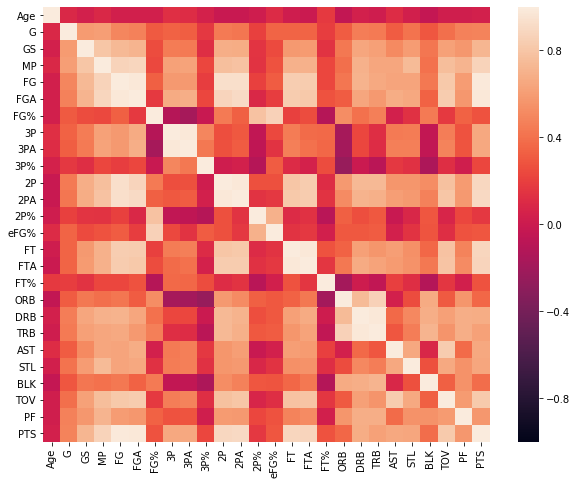

<IPython.core.display.Javascript object>

In [6]:
plt.figure(figsize=(10, 8))
sns.heatmap(nba_scaled.corr(), vmin=-1, vmax=1)
plt.show()

If we wanted to proceed with building a model, we might want to do some dimension reduction first.  Let's use factor analysis through the `factor_analyzer` package.  This package implements the commonly used `varimax` rotation [unlike `sklearn`](https://github.com/scikit-learn/scikit-learn/issues/2688) (`varimax` appears to be [under development still for `sklearn`](https://github.com/scikit-learn/scikit-learn/pull/11064) as of writing this; UPDATE 2020-02-04: Looks like varimax will be in sklearn in the next release.).

Before running a factor analysis, we need to do some "adequacy tests".  If these tests fail, we should not run a factor analysis.

> * Bartlett’s test of sphericity checks whether or not the observed variables intercorrelate at all using the observed correlation matrix against the identity matrix. If the test found statistically insignificant, you should not employ a factor analysis.
> * Kaiser-Meyer-Olkin (KMO) Test measures the suitability of data for factor analysis. It determines the adequacy for each observed variable and for the complete model. KMO estimates the proportion of variance among all the observed variable. Lower proportion id more suitable for factor analysis. KMO values range between 0 and 1. Value of KMO less than 0.6 is considered inadequate.

In [7]:
_, p_value = calculate_bartlett_sphericity(nba_scaled)
print(
    f"* Passed Bartlett adequacy test?\n\tp_value < 0.05? {p_value < 0.05} (p = {p_value:.4f})"
)

_, kmo = calculate_kmo(nba_scaled)
print(
    f"* Passed Kaiser-Meyer-Olkin adequacy test?\n\tkmo >= 0.6? {kmo >= 0.6} (kmo = {kmo:.4f})"
)

* Passed Bartlett adequacy test?
	p_value < 0.05? True (p = 0.0000)
* Passed Kaiser-Meyer-Olkin adequacy test?
	kmo >= 0.6? True (kmo = 0.8621)


/usr/local/lib/python3.7/site-packages/factor_analyzer/utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


<IPython.core.display.Javascript object>

Cool, we passed our tests. Lets get to factor analyzing.

But how many factors should we choose?  One way to do this is with the [Kaiser Criterion](https://en.wikipedia.org/wiki/Factor_analysis#Older_methods), which is nice due to its simplicity.  We calclulate some eigenvalues and count how many are above 1.  Other [more 'modern' methods](https://en.wikipedia.org/wiki/Factor_analysis#Modern_criteria) are harder to find implementations for.

In [8]:
# This will throw a FutureWarning
# (factor_analyzer version at time of writing this is 0.3.2)
fa = FactorAnalyzer(n_factors=25, rotation="varimax")
_ = fa.fit_transform(nba_scaled)
ev, _ = fa.get_eigenvalues()

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)


<IPython.core.display.Javascript object>

`matplotlib` practice!  Plot the eigenvalues (stored in `ev`)

* [ ] your x axis should be the range [1, # of eigenvalues]
* [ ] your y axis should be the eigenvalue
* [ ] plot a horizontal line at `y=1`
  * [ ] make the line dashed
  * [ ] make the line black
* [ ] for eigenvalues > 1, make the scatter marker a different color
* [ ] give the plot meaningful axis labels and a title

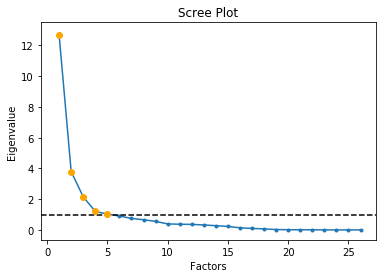

<IPython.core.display.Javascript object>

In [9]:
# Plot eigenvalues as a scree plot
idx = range(1, len(ev) + 1)
plt.plot(idx, ev, marker=".")

# Highlight points above threshold value of 1
ev_above_thresh = ev[np.where(ev > 1)]
idx = range(1, len(ev_above_thresh) + 1)
plt.scatter(idx, ev_above_thresh, c="orange", zorder=5)

# Plot threshold of 1
plt.axhline(y=1, c="black", linestyle="--")

# Pretty up
plt.title("Scree Plot")
plt.xlabel("Factors")
plt.ylabel("Eigenvalue")
plt.show()

From our candidate 25 factors, 6 meet the cutoff value of 1.  The 6th is pretty close to our cutoff, but we'll keep it in the set until it's proven not to be useful.

In [43]:
# This will throw a FutureWarning (factor_analyzer version at time of writing this is 0.3.2)
fa = FactorAnalyzer(n_factors=6, rotation="varimax")
nba_factors = fa.fit_transform(nba_scaled)

print(nba_num.shape)
print(nba_factors.shape)

(1895, 26)
(1895, 6)


/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)


<IPython.core.display.Javascript object>

We successfully trimmed down our feature set to 5... so what?  We could do that with PCA or a lot of other methods. 

Let's look at the factor `loadings_` to see how the original features map to our reduced factors.  We'll use some `pandas` styling to highlight the magnitude of each feature's contribution to the factor (note that this is the *magnitude* aka absolute value).

In [45]:
loadings = pd.DataFrame(fa.loadings_)
loadings.index = nba_num.columns
loadings.columns = [f"factor_{i}" for i in range(loadings.shape[1])]

# Sort by absolute value of column
sort_order = loadings.abs().sort_values("factor_0", ascending=False).index
loadings = loadings.reindex(sort_order)

print("Factor loadings values (colored by value)")
loadings.abs().style.background_gradient(axis=None)

Factor loadings values (colored by value)


,factor_0,factor_1,factor_2,factor_3,factor_4,factor_5
2PA,0.880501,0.369197,0.0154533,0.0811949,0.101042,0.237424
FT,0.875177,0.251554,0.191197,0.0385598,0.0854754,0.205313
FTA,0.865143,0.3277,0.102325,0.0653642,0.102401,0.221966
2P,0.855021,0.407098,0.0163897,0.201382,0.0749731,0.218013
PTS,0.838089,0.336885,0.401214,0.109013,0.090441,0.061261
FG,0.824694,0.374657,0.326947,0.148908,0.0900913,0.168292
FGA,0.817665,0.322836,0.413171,0.00355516,0.123504,0.158073
TOV,0.734783,0.286184,0.182136,0.00362827,0.480027,0.0427327
AST,0.5874,0.0330395,0.228314,0.0431837,0.689633,0.0130961
MP,0.559986,0.517973,0.441936,0.0587315,0.314438,0.261042


<IPython.core.display.Javascript object>

We can look at another correlation heatmap to see if our data is now green lit for a model that assumes no multicollinearity.

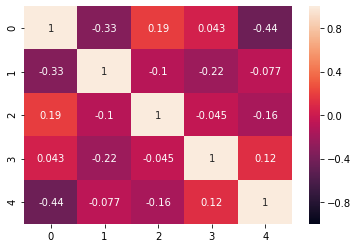

<IPython.core.display.Javascript object>

In [29]:
df = pd.DataFrame(nba_factors)
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

Let's also quickly throw `PCA` at our data to contrast the 2 methods.

From our output we see that unlike factor analysis, the loadings don't offer an easy interpretation.  However, as expected, the heatmap shows that we did end up with orthogonal components.

In [18]:
def pca_loadings(pca):
    return pca.components_.T * np.sqrt(pca.explained_variance_)

<IPython.core.display.Javascript object>

In [46]:
pca = PCA(n_components=5)
nba_pcs = pca.fit_transform(nba_scaled)

loadings = pca_loadings(pca)
loadings = pd.DataFrame(loadings)
loadings.index = nba_scaled.columns
loadings.columns = [f"component_{i}" for i in range(loadings.shape[1])]

# Sort by absolute value of column
sort_order = loadings.abs().sort_values("component_0", ascending=False).index
loadings = loadings.reindex(sort_order)

print("Component loadings absolute values (colored by magnitude)")
loadings.abs().style.background_gradient(axis=None)

Component loadings absolute values (colored by magnitude)


,component_0,component_1,component_2,component_3,component_4
FG,0.962437,0.102083,0.00521273,0.132275,0.0186262
PTS,0.957245,0.190233,0.0114714,0.141936,0.0115172
FGA,0.936031,0.262129,0.0470493,0.0894438,0.0321397
MP,0.91807,0.153605,0.0562407,0.188939,0.0389538
2P,0.913099,0.158864,0.150015,0.223825,0.0369837
2PA,0.908077,0.0490122,0.2219,0.204017,0.0347172
FTA,0.861947,0.0311495,0.212703,0.275728,0.0499049
TOV,0.855463,0.176564,0.185365,0.155804,0.0230513
FT,0.848995,0.140501,0.170977,0.291713,0.0860501
DRB,0.813111,0.350475,0.112353,0.240011,0.0151292


<IPython.core.display.Javascript object>

Let's also throw ICA in the mix.

In [49]:
ica = FastICA(n_components=5, random_state=42)
nba_ics = ica.fit_transform(nba_scaled)

loadings = pd.DataFrame(ica.mixing_)
loadings.index = nba_scaled.columns
loadings.columns = [f"ind_component_{i}" for i in range(loadings.shape[1])]

# Sort by absolute value of column
sort_order = loadings.abs().sort_values("ind_component_0", ascending=False).index
loadings = loadings.reindex(sort_order)

print("Component loadings absolute values (colored by magnitude)")
loadings.abs().style.background_gradient(axis=None)

Component loadings absolute values (colored by magnitude)


,ind_component_0,ind_component_1,ind_component_2,ind_component_3,ind_component_4
eFG%,40.2545,1.44208,1.74036,5.14065,11.0924
FG%,37.2139,2.73444,3.55614,19.7681,0.250879
2P%,35.9332,2.70177,1.89195,12.3828,2.49756
3P%,11.4465,7.35392,0.299538,20.4702,20.8963
G,8.90656,1.34519,0.336315,11.3343,28.8238
FG,7.95549,4.63142,30.1375,13.1865,25.3195
2P,7.66053,3.29331,30.5596,23.0507,15.2404
ORB,6.89329,1.85212,1.56916,38.7654,6.48533
PTS,6.78111,4.31556,31.3441,9.87517,26.422
BLK,6.12117,3.28954,1.74098,33.0745,10.1834


<IPython.core.display.Javascript object>